In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)

Files already downloaded and verified


In [3]:
def get_mean_and_std(dataset):
  '''Compute the mean and std value of dataset.'''
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  print('==> Computing mean and std..')
  for inputs, targets in dataloader:
      for i in range(3):
          mean[i] += inputs[:,i,:,:].mean()
          std[i] += inputs[:,i,:,:].std()
  mean.div_(len(dataset))
  std.div_(len(dataset))
  return mean, std

def load_data(is_train,aug,batch_size):
  dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
#   mean, std = get_mean_and_std(dataset)
#   print(mean, std)
  dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
  return dataloader

batch_size = 256 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6
[[[-0.9147032  -0.38956204  0.0274618  ...  0.01201648  0.18191507
    0.15102442]
  [-0.32778072 -0.03431951  0.10468844 ... -0.21966343  0.1973604
    0.2591417 ]
  [-0.09610081  0.29003236  0.24369638 ... -0.6366873  -0.51312464
   -0.32778072]
  ...
  [ 1.0931895   1.2321974   1.448432   ...  0.22825105  0.66072035
    1.6646665 ]
  [ 1.2013068   1.3248694   1.3866507  ... -0.38956204 -0.17332745
    1.1704161 ]
  [ 1.3866507   1.2785335   1.1549708  ... -0.8529219  -0.8065859
    0.7997283 ]]

 [[-1.2393323  -0.8772444  -0.53089947 ... -0.5151565  -0.3419841
   -0.3419841 ]
  [-0.8142726  -0.6725861  -0.5623854  ... -0.68832904 -0.32624117
   -0.29475525]
  [-0.6411001  -0.42069885 -0.45218474 ... -1.003188   -0.9244732
   -0.76704377]
  ...
  [ 0.57110703  0.6813077   0.9804237  ... -0.21604052  0.19327614
    1.2323109 ]
  [ 0.6025929   0.74427944  0.8229942  ... -0.83001554 -0.68832904
    0.6655647 ]
  [ 0.87022305  0.8072512   0.6340788  ... -1.12913

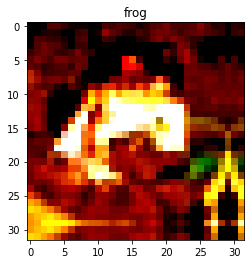

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
image_= np.array(image).copy()
print(image.shape, label)
print(image_)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [5]:
# trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=batch_size,shuffle=True)
# testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=batch_size,shuffle=False)

# images, labels = iter(trainDataLoader).next()
# plt.figure(figsize=(17,8))
# for index in np.arange(0,5):
#   plt.subplot(1,5,index+1)
#   plt.imshow(images[index].numpy().transpose(1,2,0))
#   plt.title(str(classes[labels[index]]))

def get_mean_and_std(dataset):
  '''Compute the mean and std value of dataset.'''
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  print('==> Computing mean and std..')
  for inputs, targets in dataloader:
      for i in range(3):
          mean[i] += inputs[:,i,:,:].mean()
          std[i] += inputs[:,i,:,:].std()
  mean.div_(len(dataset))
  std.div_(len(dataset))
  return mean, std


In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, in_planes, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = in_planes

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, in_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, in_planes*2, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, in_planes*4, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, in_planes*8, num_blocks[3], stride=2)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, self.in_planes*8, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
#         out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
#     return ResNet(BasicBlock, [2, 2, 2])
    return ResNet(64, BasicBlock, [13, 13])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4759370


In [8]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [ ]:
num_epochs = 500 # param
epoch_start = 0
# path = 'adam_rotate_center_crop1.pt'
# path = 'block_3.pt'
path = 'no_crop_decay_layer_2.pt'

train_loss_history = []
test_loss_history = []
test_accuracy_history = []
train_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()
lr = 0.8 # param
lr_min=0.001
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4) # changable optimizer
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9) # changable optimizer
# optimizer = torch.optim.Adam(model1.parameters(),lr=lr, betas=(0.9,0.999), eps=1e-08, amsgrad=False) # changable optimizer
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)

# torch.cuda.empty_cache()

if os.path.exists(path):
  checkpoint = torch.load(path)
  print('Read model from checkpoint')
  model1.cuda().load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch_start = checkpoint['epoch']
  Loss = checkpoint['Loss']
  train_loss_history = checkpoint['train_loss_history']
  test_loss_history = checkpoint['test_loss_history']
  test_accuracy_history = checkpoint['test_accuracy_history']
  train_accuracy_history = checkpoint['train_accuracy_history']
  print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs + 1):
  timestart = time.time()

  train_loss = 0.0
  test_loss = 0.0
  test_accuracy = 0.0
  train_accuracy = 0.0

  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = model1.cuda()(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
    optimizer.step()
    train_loss += fit.item()
    train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = model1.cuda()(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
      test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  test_accu = test_accuracy/len(testDataLoader)
  train_accu = train_accuracy/len(trainDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  test_accuracy_history.append(test_accu)
  train_accuracy_history.append(train_accu)
  print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))
  
  if epoch % 5 == 0 and epoch != 0:
    torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'test_accuracy_history':test_accuracy_history,
          'train_accuracy_history':train_accuracy_history},path)
    print('Model saved in epoch %s'%(epoch))

Read model from checkpoint
Restart from epoch 195
Epoch 196, Train loss 0.006647222267474717, Test loss 0.6047039970755577, Train accuracy 99.76243622448979, Test accuracy 91.376953125, Cost 109.02971696853638 s
Epoch 197, Train loss 0.00844915031150461, Test loss 0.6641840055584908, Train accuracy 99.74848533163265, Test accuracy 90.849609375, Cost 107.68977761268616 s
Epoch 198, Train loss 0.009750998162825436, Test loss 0.6022374585270882, Train accuracy 99.71699617346938, Test accuracy 91.728515625, Cost 107.69355320930481 s
Epoch 199, Train loss 0.006913046790273535, Test loss 0.5967893071472645, Train accuracy 99.80229591836735, Test accuracy 91.34765625, Cost 107.76402235031128 s
Epoch 200, Train loss 0.009908237907179032, Test loss 0.6130330167710781, Train accuracy 99.65720663265306, Test accuracy 91.142578125, Cost 107.70240354537964 s
Model saved in epoch 200
Epoch 201, Train loss 0.0066390577835498295, Test loss 0.638595775142312, Train accuracy 99.79272959183673, Test accu

Epoch 246, Train loss 0.000858381261463949, Test loss 0.6932807303965092, Train accuracy 99.9740911989796, Test accuracy 91.748046875, Cost 107.91341662406921 s
Epoch 247, Train loss 0.0010272745192901776, Test loss 0.7494940169155597, Train accuracy 99.97010522959184, Test accuracy 91.69921875, Cost 107.91545724868774 s
Epoch 248, Train loss 0.0017750081958290455, Test loss 0.7145675279200077, Train accuracy 99.93622448979592, Test accuracy 91.875, Cost 107.89086413383484 s
Epoch 249, Train loss 0.0016216651752770583, Test loss 0.712637796998024, Train accuracy 99.94818239795919, Test accuracy 91.650390625, Cost 107.90723514556885 s
Epoch 250, Train loss 0.003200890031574981, Test loss 0.6881431996822357, Train accuracy 99.91350446428571, Test accuracy 91.5625, Cost 107.90417265892029 s
Model saved in epoch 250
Epoch 251, Train loss 0.003606039850146029, Test loss 0.6712474167346955, Train accuracy 99.87444196428571, Test accuracy 91.42578125, Cost 107.80873966217041 s
Epoch 252, Trai

Epoch 296, Train loss 0.0017110989378779221, Test loss 0.7145981349050998, Train accuracy 99.93622448979592, Test accuracy 92.138671875, Cost 107.621577501297 s
Epoch 297, Train loss 0.0006725688595919593, Test loss 0.7454659417271614, Train accuracy 99.98405612244898, Test accuracy 92.2265625, Cost 107.67398285865784 s
Epoch 298, Train loss 0.0005828370217873921, Test loss 0.7549695044755935, Train accuracy 99.98405612244898, Test accuracy 92.1484375, Cost 107.60909152030945 s
Epoch 299, Train loss 0.0005127078723838432, Test loss 0.747214549779892, Train accuracy 99.98007015306122, Test accuracy 92.12890625, Cost 107.66761517524719 s
Epoch 300, Train loss 0.0002487004057175046, Test loss 0.730000538378954, Train accuracy 99.99402104591837, Test accuracy 92.138671875, Cost 107.63024353981018 s
Model saved in epoch 300
Epoch 301, Train loss 0.0003798958843515498, Test loss 0.7364995442330837, Train accuracy 99.98804209183673, Test accuracy 92.119140625, Cost 107.76270699501038 s
Epoch 

Epoch 346, Train loss 8.322490509089191e-05, Test loss 0.7673984244465828, Train accuracy 99.99800701530613, Test accuracy 92.2265625, Cost 107.38399648666382 s
Epoch 347, Train loss 8.958480629375481e-05, Test loss 0.767323586344719, Train accuracy 99.99800701530613, Test accuracy 92.24609375, Cost 107.3498375415802 s
Epoch 348, Train loss 7.711545343189922e-05, Test loss 0.7739488713443279, Train accuracy 99.99800701530613, Test accuracy 92.24609375, Cost 107.31256794929504 s
Epoch 349, Train loss 8.632947293012087e-05, Test loss 0.7750222831964493, Train accuracy 100.0, Test accuracy 92.28515625, Cost 107.2639992237091 s
Epoch 350, Train loss 8.910264404748051e-05, Test loss 0.7832460157573223, Train accuracy 99.99800701530613, Test accuracy 92.255859375, Cost 107.3212456703186 s
Model saved in epoch 350
Epoch 351, Train loss 0.00010297395811693326, Test loss 0.7767667882144451, Train accuracy 99.99800701530613, Test accuracy 92.177734375, Cost 107.40083479881287 s
Epoch 352, Train 

Epoch 396, Train loss 7.683147002821306e-05, Test loss 0.7985291078686714, Train accuracy 100.0, Test accuracy 92.16796875, Cost 107.52732920646667 s
Epoch 397, Train loss 9.029201882309137e-05, Test loss 0.7933951281011105, Train accuracy 99.99800701530613, Test accuracy 92.236328125, Cost 107.49955797195435 s
Epoch 398, Train loss 8.331968000257925e-05, Test loss 0.7955646678805351, Train accuracy 99.99800701530613, Test accuracy 92.20703125, Cost 107.50492024421692 s
Epoch 399, Train loss 7.408420809527492e-05, Test loss 0.7963355608284474, Train accuracy 99.99800701530613, Test accuracy 92.216796875, Cost 107.48060536384583 s
Epoch 400, Train loss 0.00012952360725779268, Test loss 0.7881931215524673, Train accuracy 99.99601403061224, Test accuracy 92.275390625, Cost 107.48997211456299 s
Model saved in epoch 400
Epoch 401, Train loss 3.7148915503535114e-05, Test loss 0.7892805933952332, Train accuracy 100.0, Test accuracy 92.255859375, Cost 107.50209045410156 s
Epoch 402, Train loss

Epoch 447, Train loss 7.939048468781714e-05, Test loss 0.7866776637732983, Train accuracy 99.99800701530613, Test accuracy 92.353515625, Cost 107.40647292137146 s
Epoch 448, Train loss 9.358910660640221e-05, Test loss 0.7879450529813766, Train accuracy 99.99800701530613, Test accuracy 92.314453125, Cost 107.39334344863892 s
Epoch 449, Train loss 8.035313725470206e-05, Test loss 0.7880886860191822, Train accuracy 99.99800701530613, Test accuracy 92.32421875, Cost 107.42376494407654 s
Epoch 450, Train loss 9.065689997477913e-05, Test loss 0.788144101947546, Train accuracy 99.99800701530613, Test accuracy 92.294921875, Cost 107.33413314819336 s
Model saved in epoch 450
Epoch 451, Train loss 2.5772049282949473e-05, Test loss 0.7882686063647271, Train accuracy 100.0, Test accuracy 92.28515625, Cost 107.40979242324829 s
Epoch 452, Train loss 3.7819006462473573e-05, Test loss 0.7884776756167412, Train accuracy 100.0, Test accuracy 92.28515625, Cost 107.41522431373596 s
Epoch 453, Train loss 8

In [ ]:
num_epochs = 611
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
# plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [ ]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)